In [2]:
!git clone https://github.com/Etienne-bdt/BEI-SIA25
!unzip /content/BEI-SIA25/data.zip -d /content/BEI-SIA25/

Cloning into 'BEI-SIA25'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 251 (delta 65), reused 48 (delta 48), pack-reused 148 (from 3)
Receiving objects: 100% (251/251), 110.98 MiB | 22.82 MiB/s, done.
Resolving deltas: 100% (116/116), done.
Archive:  /content/BEI-SIA25/data.zip
   creating: /content/BEI-SIA25/data/
   creating: /content/BEI-SIA25/data/31000/
   creating: /content/BEI-SIA25/data/31000/patches/
  inflating: /content/BEI-SIA25/data/31000/patches/192_192_after.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/192_192_before.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/192_192_mask.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/448_384_after.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/448_384_before.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/448_384_mask.npy  
  inflating: /content/BEI-SIA25/data/31000/patches/44

In [3]:
import sys
sys.path.append("/content/BEI-SIA25")

In [4]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

from utils.dataloader import CadastreSen2Dataset
from utils.index_calculation import BSI, NDBI, NDMI, NDVI, NDWI

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the data

Get the data

Prepare pytorch dataset

In [6]:
dataset = CadastreSen2Dataset(image_path="/content/BEI-SIA25/data/")

Prepare dataloader

In [7]:
batch_size = 16
num_threads = 0

#Split into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)

# Model definition

In [82]:
class Conv2DRegressionModel(nn.Module):
    def __init__(self, int_channels: int = 11):
        super(Conv2DRegressionModel, self).__init__()
        self.nb_channel = int_channels
        self.enc1 = nn.Sequential(
            nn.Conv2d(int_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.Tanh()
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        y = self.enc1(X)
        enc1_out = y
        y = self.enc2(y)
        enc2_out = y
        y = self.enc3(y)
        enc3_out = y
        y = self.enc4(y)
        y = self.dec4(y)
        y = torch.cat((y, enc3_out), dim=1)
        y = self.dec3(y)
        y = torch.cat((y, enc2_out), dim=1)
        y = self.dec2(y)
        y = torch.cat((y, enc1_out), dim=1)
        y = self.dec1(y)
        y[0:3]=y[0:3]/
        return y

class DiffusionModel(nn.Module):
    def __init__(self, timesteps=1000, beta_start=0.0001, beta_end=0.02):
        super(DiffusionModel, self).__init__()
        self.timesteps = timesteps
        self.beta = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0).to(device)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), self.alpha_cumprod[:-1]]).to(device)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod).to(device)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alpha_cumprod).to(device)
        self.posterior_variance = self.beta * (1.0 - self.alpha_cumprod_prev) / (1.0 - self.alpha_cumprod)

        self.model = nn.Sequential(
            nn.Conv2d(11, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x, mask, t):
        noise = torch.randn_like(x).to(device)
        x_t = self.sqrt_alpha_cumprod[t] * x + self.sqrt_one_minus_alpha_cumprod[t] * noise
        return self.model(torch.cat((x_t * (1 - mask), mask), dim=1))

    def p_losses(self, x_start, mask, t):
        noise = torch.randn_like(x_start)
        x_noisy = self.sqrt_alpha_cumprod[t] * x_start + self.sqrt_one_minus_alpha_cumprod[t] * noise
        predicted_noise = self.forward(x_noisy, mask, t)
        return nn.MSELoss()(predicted_noise, noise)

    def sample(self, x, mask):
        for t in reversed(range(self.timesteps)):
            t_tensor = torch.tensor([t]).to(device)
            predicted_noise = self.forward(x, mask, t_tensor)
            if t > 0:
                noise = torch.randn_like(x)
                x = (x - (1 - self.alpha[t]) / torch.sqrt(1 - self.alpha_cumprod[t]) * predicted_noise) / torch.sqrt(self.alpha[t]) + torch.sqrt(self.posterior_variance[t]) * noise
            else:
                x = (x - (1 - self.alpha[t]) / torch.sqrt(1 - self.alpha_cumprod[t]) * predicted_noise) / torch.sqrt(self.alpha[t])
        return x

# Train the model

In [9]:
from skimage.metrics import structural_similarity as ssim


In [83]:
n_epochs = 50
learning_rate = 0.001

model = Conv2DRegressionModel()
model = model.to(device)


#metric = im.SSIM(data_range=1.0)
# metric.attach(im.default_evaluator, 'ssim')
# preds = torch.rand([4, 3, 16, 16])
# target = preds * 0.75
# state = im.default_evaluator.run([[preds, target]])
# print(state.metrics['ssim'])

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_set_len = len(train_loader)
val_set_len = len(val_loader)

train_loss_comp, val_loss_comp = [], []
train_loss_pred, val_loss_pred = [], []
train_loss_comp_pred, val_loss_comp_pred = [], []
train_loss_tot, val_loss_tot = [], []
train_loss_visu, val_loss_visu = [], []
ssim_vals = []
best_loss=1000000
for epoch in tqdm(range(n_epochs)):
    model.train()
    accu_visual = 0.0
    accu_comp = 0.0
    accu_pred = 0.0
    accu_comp_pred = 0.0
    accu_total = 0.0
    ssim_v = 0

    for x, y, mask in train_loader:
        x,y,mask = x.to(device), y.to(device), mask.to(device)
        x,y,mask = x.float(), y.float(), mask.float()
        optimizer.zero_grad()
        # img_2018, img_2024 = img_2018.to(device), img_2024.to(device)
        # Forward pass
        x=torch.cat([x,mask],axis=1)
        y_pred = model(x) # image 2024 prédite à partir de 2018

        Ind_comp = NDVI(y_pred)
        Ind_comp = torch.cat((Ind_comp, NDWI(y_pred)), dim=1)
        Ind_comp = torch.cat((Ind_comp, NDBI(y_pred)), dim=1)
        Ind_comp = torch.cat((Ind_comp, NDMI(y_pred)), dim=1)
        Ind_comp = torch.cat((Ind_comp, BSI(y_pred)), dim=1)

        # Ind_real = y[:,[5,8],:,:]
        Ind_real = y[:,5:,:,:]
        # print("ind real shape",Ind_real.shape)
        Ind_pred = y_pred[:,5:,:,:]
        # Ind_pred = y_pred
        weights = torch.tensor([0.4, 0.2, 0.2, 0.1, 0.1], device=device) # pondération à ajuster
        # weights = torch.tensor([0.5, 0.5], device=device)

        visual_loss = loss_fn(y_pred[:,0:3,:,:], y_pred[:,0:3,:,:]) # loss globale
        loss_comp = sum(w * loss_fn(comp, true) for w, comp, true in zip(weights, Ind_comp, Ind_real)) # comparaison des indices calculés
        # loss_pred = loss_fn(y[:,[5,8],:,:], y_pred)
        loss_pred = sum(w * loss_fn(pred, true) for w, pred, true in zip(weights, Ind_pred, Ind_real)) # comparaison des indices reel et prédits
        loss_comp_pred = sum(w * loss_fn(comp, pred) for w, comp, pred in zip(weights, Ind_comp, Ind_pred)) # comparaison des indices calculés et prédits

        total_loss = 2*visual_loss + loss_comp + loss_pred + loss_comp_pred
        # total_loss=loss_pred
        accu_visual += visual_loss.item()
        accu_comp += loss_comp.item()
        accu_pred += loss_pred.item()
        accu_comp_pred += loss_comp_pred.item()
        accu_total += total_loss.item()
        # Backward pass
        total_loss.backward()
        optimizer.step()

    train_loss_visu.append(accu_visual/val_set_len)
    train_loss_comp.append(accu_comp / train_set_len)
    train_loss_pred.append(accu_pred / train_set_len)
    train_loss_comp_pred.append(accu_comp_pred / train_set_len)
    train_loss_tot.append(accu_total / train_set_len)
    # Validation - no gradient & eval mode
    model.eval()
    accu_visual = 0.0
    accu_comp = 0.0
    accu_pred = 0.0
    accu_comp_pred = 0.0
    accu_total = 0.0
    ssim_v = 0
    nb_iter=0
    with torch.no_grad():
        for x, y, mask in val_loader:
            x,y,mask = x.to(device), y.to(device), mask.to(device)
            x,y,mask = x.float(), y.float(), mask.float()

            x=torch.cat([x,mask],axis=1)
            y_pred = model(x)
            Ind_comp = NDVI(y_pred)
            Ind_comp = torch.cat((Ind_comp, NDWI(y_pred)), dim=1)
            Ind_comp = torch.cat((Ind_comp, NDBI(y_pred)), dim=1)
            Ind_comp = torch.cat((Ind_comp, NDMI(y_pred)), dim=1)
            Ind_comp = torch.cat((Ind_comp, BSI(y_pred)), dim=1)
            # Ind_real = y[:,[5,8],:,:]
            Ind_real = y[:,5:,:,:]
            # print("ind real shape",Ind_real.shape)
            Ind_pred = y_pred[:,5:,:,:]
            # Ind_pred = y_pred
            # print("ind pred shape",Ind_pred.shape)

            weights = torch.tensor([0.4, 0.2, 0.2, 0.1, 0.1], device=device) # pondération à ajuster

            visual_loss = loss_fn(y_pred[:,0:3,:,:], y_pred[:,0:3,:,:])
            loss_comp = sum(w * loss_fn(comp, true) for w, comp, true in zip(weights, Ind_comp, Ind_real))
            # loss_pred = loss_fn(y[:,[5,8],:,:], y_pred)
            loss_pred = sum(w * loss_fn(pred, true) for w, pred, true in zip(weights, Ind_pred, Ind_real)) # comparaison des indices reel et prédits
            loss_comp_pred = sum(w * loss_fn(comp, pred) for w, comp, pred in zip(weights, Ind_comp, Ind_pred))
            total_loss = 2*visual_loss + loss_comp + loss_pred + loss_comp_pred
            # total_loss=loss_pred
            accu_visual += visual_loss.item()
            accu_comp += loss_comp.item()
            accu_pred += loss_pred.item()
            accu_comp_pred += loss_comp_pred.item()
            accu_total += total_loss.item()
            for i in range(y.shape[0]):
              nb_iter+=1
              ssim_v += ssim(y[i,5,:,:].cpu().detach().numpy(),y_pred[i,5,:,:].cpu().detach().numpy(), data_range=2)
              ssim_v += ssim(y[i,6,:,:].cpu().detach().numpy(),y_pred[i,6,:,:].cpu().detach().numpy(), data_range=2)
              ssim_v += ssim(y[i,7,:,:].cpu().detach().numpy(),y_pred[i,7,:,:].cpu().detach().numpy(), data_range=2)
              ssim_v += ssim(y[i,8,:,:].cpu().detach().numpy(),y_pred[i,8,:,:].cpu().detach().numpy(), data_range=2)
              ssim_v += ssim(y[i,9,:,:].cpu().detach().numpy(),y_pred[i,9,:,:].cpu().detach().numpy(), data_range=2)
    val_loss_visu.append(accu_visual/val_set_len)
    val_loss_comp.append(accu_comp / val_set_len)
    val_loss_pred.append(accu_pred / val_set_len)
    val_loss_comp_pred.append(accu_comp_pred / val_set_len)
    val_loss_tot.append(accu_total / val_set_len)
    ssim_vals.append(ssim_v/ (5*nb_iter))

    if accu_total < best_loss:
        best_loss = accu_total
        torch.save(model.state_dict(), "best_model.pt")

    if epoch % 1 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs} - Train loss: {train_loss_tot[-1]:.4f} - Val loss: {val_loss_tot[-1]:.4f} - SSIM val: {ssim_vals[-1]:.4f}")

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"model_{epoch}.pt")


  2%|▏         | 1/50 [00:00<00:20,  2.41it/s]

Epoch 1/50 - Train loss: 6315100.1719 - Val loss: 260657.1328 - SSIM val: -0.0189


  4%|▍         | 2/50 [00:00<00:17,  2.82it/s]

Epoch 2/50 - Train loss: 250323348.8880 - Val loss: 3983289.6094 - SSIM val: -0.0346


  6%|▌         | 3/50 [00:01<00:15,  2.96it/s]

Epoch 3/50 - Train loss: 230004345.7865 - Val loss: 254875.1211 - SSIM val: -0.0177


  8%|▊         | 4/50 [00:01<00:14,  3.07it/s]

Epoch 4/50 - Train loss: 35302081146.6940 - Val loss: 1469051.4531 - SSIM val: 0.0328


 10%|█         | 5/50 [00:01<00:14,  3.01it/s]

Epoch 5/50 - Train loss: 23471011.9674 - Val loss: 131629.4883 - SSIM val: 0.0351


 12%|█▏        | 6/50 [00:02<00:14,  3.06it/s]

Epoch 6/50 - Train loss: 21229336.8750 - Val loss: 442981.9453 - SSIM val: 0.0196


 14%|█▍        | 7/50 [00:02<00:13,  3.12it/s]

Epoch 7/50 - Train loss: 69324170.4792 - Val loss: 484769.8281 - SSIM val: 0.0186


 16%|█▌        | 8/50 [00:02<00:13,  3.17it/s]

Epoch 8/50 - Train loss: 47261933.7083 - Val loss: 108386420.2500 - SSIM val: 0.0204


 18%|█▊        | 9/50 [00:02<00:12,  3.19it/s]

Epoch 9/50 - Train loss: 2711386307.5885 - Val loss: 18952413185.5000 - SSIM val: 0.0106


 20%|██        | 10/50 [00:03<00:12,  3.18it/s]

Epoch 10/50 - Train loss: 209839417.3333 - Val loss: 239311513600.0000 - SSIM val: 0.0115


 22%|██▏       | 11/50 [00:03<00:12,  3.17it/s]

Epoch 11/50 - Train loss: 40966468986.6667 - Val loss: 2148941.2500 - SSIM val: 0.0239


 24%|██▍       | 12/50 [00:03<00:11,  3.17it/s]

Epoch 12/50 - Train loss: 37016167112.0833 - Val loss: 834467.5781 - SSIM val: 0.0307


 26%|██▌       | 13/50 [00:04<00:11,  3.19it/s]

Epoch 13/50 - Train loss: 17339931731.0000 - Val loss: 3054484.7031 - SSIM val: 0.0153


 28%|██▊       | 14/50 [00:04<00:11,  3.15it/s]

Epoch 14/50 - Train loss: 306650642450.8750 - Val loss: 40698887.3906 - SSIM val: 0.0100


 30%|███       | 15/50 [00:04<00:11,  3.16it/s]

Epoch 15/50 - Train loss: 71211145094.7214 - Val loss: 23564289.0000 - SSIM val: 0.0067


 32%|███▏      | 16/50 [00:05<00:10,  3.18it/s]

Epoch 16/50 - Train loss: 425871086.2396 - Val loss: 106808228348.0000 - SSIM val: 0.0125


 34%|███▍      | 17/50 [00:05<00:10,  3.20it/s]

Epoch 17/50 - Train loss: 3157597.5156 - Val loss: 41930188.5000 - SSIM val: 0.0158


 36%|███▌      | 18/50 [00:05<00:09,  3.20it/s]

Epoch 18/50 - Train loss: 134444008653.7982 - Val loss: 1099484.9844 - SSIM val: 0.0302


 38%|███▊      | 19/50 [00:06<00:09,  3.20it/s]

Epoch 19/50 - Train loss: 449955.8340 - Val loss: 290558.4688 - SSIM val: 0.0178


 40%|████      | 20/50 [00:06<00:09,  3.20it/s]

Epoch 20/50 - Train loss: 233282729.3281 - Val loss: 908083.5938 - SSIM val: 0.0089


 42%|████▏     | 21/50 [00:06<00:09,  3.17it/s]

Epoch 21/50 - Train loss: 14434495.0104 - Val loss: 691948.7031 - SSIM val: 0.0061


 44%|████▍     | 22/50 [00:07<00:08,  3.17it/s]

Epoch 22/50 - Train loss: 12557747.3021 - Val loss: 209660396.0000 - SSIM val: 0.0101


 46%|████▌     | 23/50 [00:07<00:08,  3.19it/s]

Epoch 23/50 - Train loss: 103694521.3646 - Val loss: 357288.2656 - SSIM val: 0.0103


 48%|████▊     | 24/50 [00:07<00:08,  3.18it/s]

Epoch 24/50 - Train loss: 1057002911.0833 - Val loss: 23763691.5000 - SSIM val: 0.0074


 50%|█████     | 25/50 [00:07<00:07,  3.16it/s]

Epoch 25/50 - Train loss: 9860230.4583 - Val loss: 94581223.7500 - SSIM val: 0.0119


 52%|█████▏    | 26/50 [00:08<00:07,  3.16it/s]

Epoch 26/50 - Train loss: 1371137.8620 - Val loss: 3042520.3125 - SSIM val: 0.0135


 54%|█████▍    | 27/50 [00:08<00:07,  3.16it/s]

Epoch 27/50 - Train loss: 5202810.5000 - Val loss: 3662521.1250 - SSIM val: 0.0177


 56%|█████▌    | 28/50 [00:08<00:07,  3.14it/s]

Epoch 28/50 - Train loss: 56898338027.6927 - Val loss: 124638.6953 - SSIM val: 0.0069


 58%|█████▊    | 29/50 [00:09<00:06,  3.13it/s]

Epoch 29/50 - Train loss: 1127891.7448 - Val loss: 3810159.5625 - SSIM val: 0.0128


 60%|██████    | 30/50 [00:09<00:06,  3.16it/s]

Epoch 30/50 - Train loss: 1006578528.2760 - Val loss: 2404679.5000 - SSIM val: 0.0032


 62%|██████▏   | 31/50 [00:09<00:06,  2.97it/s]

Epoch 31/50 - Train loss: 20917723.6042 - Val loss: 7142556.1250 - SSIM val: 0.0073


 64%|██████▍   | 32/50 [00:10<00:08,  2.23it/s]

Epoch 32/50 - Train loss: 17575628.9844 - Val loss: 711684.8750 - SSIM val: 0.0052


 66%|██████▌   | 33/50 [00:11<00:08,  1.93it/s]

Epoch 33/50 - Train loss: 7711795.3073 - Val loss: 491534.2812 - SSIM val: 0.0036


 68%|██████▊   | 34/50 [00:11<00:07,  2.08it/s]

Epoch 34/50 - Train loss: 18372100.6667 - Val loss: 1117742.1562 - SSIM val: 0.0019


 70%|███████   | 35/50 [00:12<00:06,  2.22it/s]

Epoch 35/50 - Train loss: 2636774.4297 - Val loss: 307370.5977 - SSIM val: 0.0003


 72%|███████▏  | 36/50 [00:12<00:05,  2.41it/s]

Epoch 36/50 - Train loss: 9032150.6146 - Val loss: 838917.3594 - SSIM val: -0.0031


 74%|███████▍  | 37/50 [00:12<00:05,  2.57it/s]

Epoch 37/50 - Train loss: 1020534.7871 - Val loss: 467459.5859 - SSIM val: -0.0025


 76%|███████▌  | 38/50 [00:13<00:04,  2.74it/s]

Epoch 38/50 - Train loss: 1418700656.7500 - Val loss: 15484904.9688 - SSIM val: 0.0004


 78%|███████▊  | 39/50 [00:13<00:03,  2.87it/s]

Epoch 39/50 - Train loss: 1243318.7214 - Val loss: 145717.3320 - SSIM val: 0.0044


 80%|████████  | 40/50 [00:13<00:03,  2.96it/s]

Epoch 40/50 - Train loss: 3591158.1130 - Val loss: 3890899.4062 - SSIM val: 0.0026


 82%|████████▏ | 41/50 [00:14<00:03,  2.96it/s]

Epoch 41/50 - Train loss: 3527861.0592 - Val loss: 2749996.0000 - SSIM val: 0.0037


 84%|████████▍ | 42/50 [00:14<00:02,  3.01it/s]

Epoch 42/50 - Train loss: 2578546.8958 - Val loss: 63673833.0000 - SSIM val: 0.0017


 86%|████████▌ | 43/50 [00:14<00:02,  3.02it/s]

Epoch 43/50 - Train loss: 22818993.9948 - Val loss: 516089.7500 - SSIM val: 0.0093


 88%|████████▊ | 44/50 [00:15<00:01,  3.03it/s]

Epoch 44/50 - Train loss: 201871366.5443 - Val loss: 1514964.7344 - SSIM val: 0.0136


 90%|█████████ | 45/50 [00:15<00:01,  3.06it/s]

Epoch 45/50 - Train loss: 603524.7318 - Val loss: 717152.6250 - SSIM val: 0.0140


 92%|█████████▏| 46/50 [00:15<00:01,  3.09it/s]

Epoch 46/50 - Train loss: 71521290.3125 - Val loss: 4239614.7500 - SSIM val: 0.0064


 94%|█████████▍| 47/50 [00:15<00:00,  3.08it/s]

Epoch 47/50 - Train loss: 39718094.1302 - Val loss: 1072584.8125 - SSIM val: 0.0045


 96%|█████████▌| 48/50 [00:16<00:00,  3.09it/s]

Epoch 48/50 - Train loss: 1424608.1172 - Val loss: 1000701.4375 - SSIM val: 0.0078


 98%|█████████▊| 49/50 [00:16<00:00,  3.10it/s]

Epoch 49/50 - Train loss: 561064.0104 - Val loss: 687102.3281 - SSIM val: 0.0089


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]

Epoch 50/50 - Train loss: 331955027.0625 - Val loss: 230562.2598 - SSIM val: 0.0103


In [11]:
x,y,m = next(iter(val_loader))


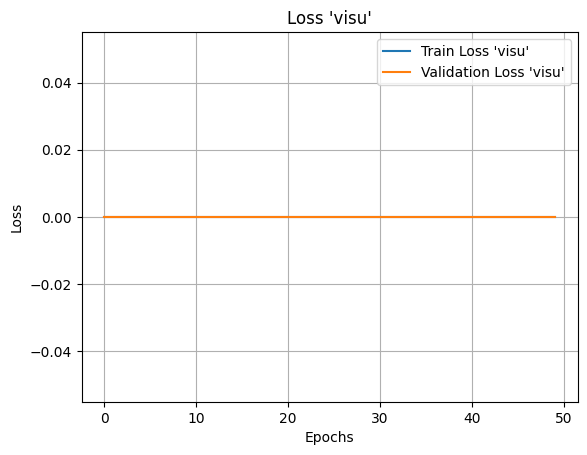

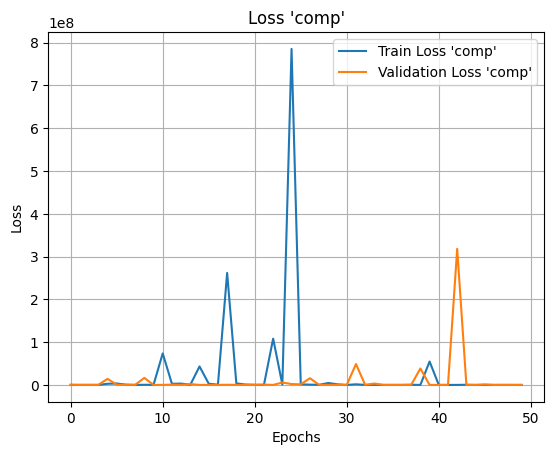

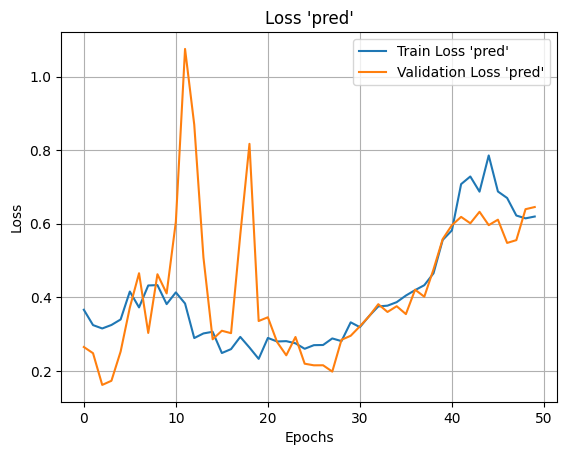

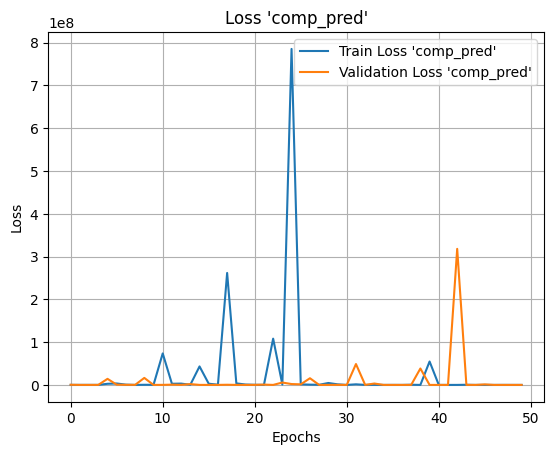

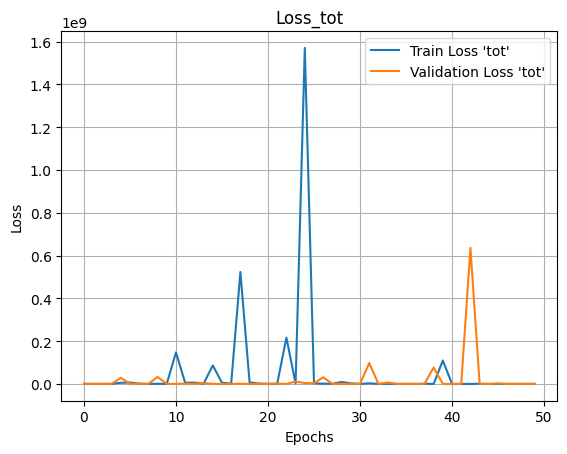

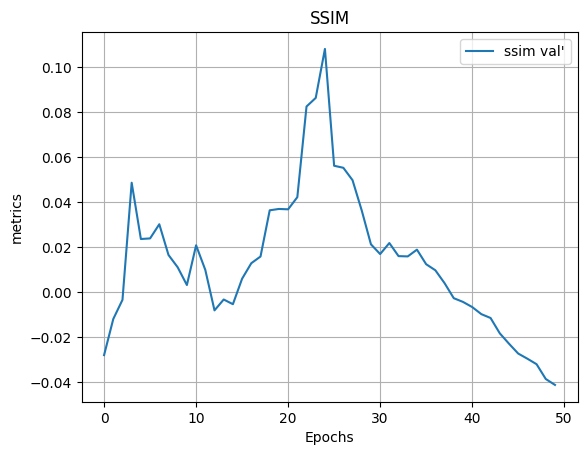

In [80]:
plt.plot(train_loss_visu, label="Train Loss 'visu'")
plt.plot(val_loss_visu, label="Validation Loss 'visu'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss 'visu'")
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_comp, label="Train Loss 'comp'")
plt.plot(val_loss_comp, label="Validation Loss 'comp'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss 'comp'")
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_pred, label="Train Loss 'pred'")
plt.plot(val_loss_pred, label="Validation Loss 'pred'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss 'pred'")
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_comp_pred, label="Train Loss 'comp_pred'")
plt.plot(val_loss_comp_pred, label="Validation Loss 'comp_pred'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss 'comp_pred'")
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_tot, label="Train Loss 'tot'")
plt.plot(val_loss_tot, label="Validation Loss 'tot'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss_tot")
plt.legend()
plt.grid()
plt.show()

plt.plot(ssim_vals, label="ssim val'")
# plt.plot(val_loss_visu, label="Validation Loss 'visu'")
plt.xlabel("Epochs")
plt.ylabel("metrics")
plt.title("SSIM")
plt.legend()
plt.grid()

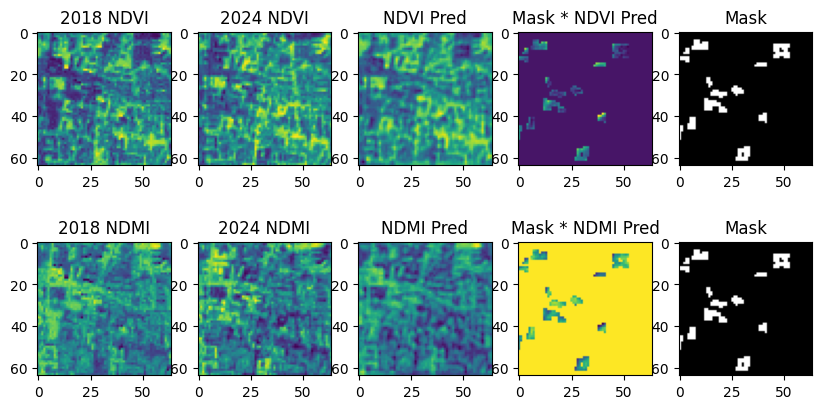

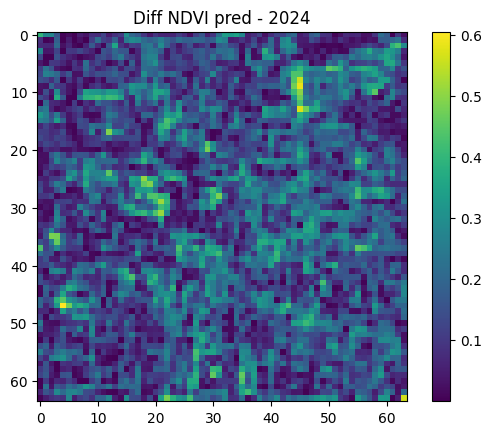

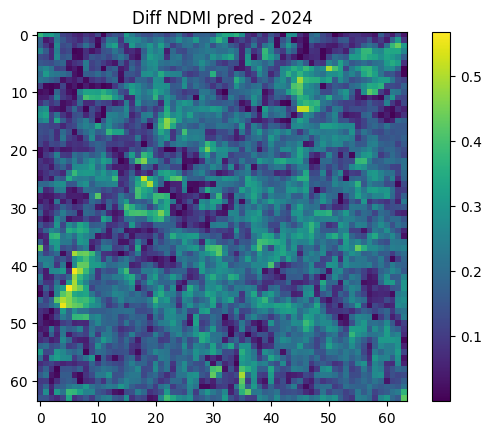

mean diff NDVI pred - real 0.1565901
mean diff NDWI pred - real 0.18303776


In [67]:
model.cpu()

x,y,mask = next(iter(val_loader))
x,y,mask = x.float(), y.float(), mask.float()
# x,y,mask = x[0:1,:,:,:], y[0:1,:,:,:], mask[0:1,:,:,:]
# x,y,mask = x.cpu(), y.tocpu(), mask.to(device)
x=torch.cat([x,mask],axis=1)
y_pred = model(x)
batch_img=0
fig, ax = plt.subplots(2, 5, figsize=(10,5))
# ax[0, 0].imshow((x[batch_img, 0:3, :, :]).permute(1,2,0).detach().numpy())
# ax[0, 1].imshow(y[batch_img, 0:3, :, :].permute(1,2,0).detach().numpy())
# ax[0, 2].imshow(y_pred[batch_img, 0:3, :, :].permute(1,2,0).detach().numpy())

# ax[1, 0].imshow(x[batch_img, 5, :, :].detach().numpy())
# ax[1, 1].imshow(y[batch_img, 5, :, :].detach().numpy())
# ax[1, 2].imshow(y_pred[batch_img, 5, :, :].detach().numpy())
ax[0, 0].imshow((x[batch_img, 5, :, :]).detach().numpy())
ax[0, 0].title.set_text('2018 NDVI')
ax[0, 1].imshow(y[batch_img, 5, :, :].detach().numpy())
ax[0, 1].title.set_text('2024 NDVI')
ax[0, 2].imshow(y_pred[batch_img, 0, :, :].detach().numpy())
ax[0, 2].title.set_text('NDVI Pred')
ax[0, 3].imshow((y_pred[batch_img, 0, :, :]*mask[batch_img,0,:,:]).detach().numpy())
ax[0, 3].title.set_text('Mask * NDVI Pred')
ax[0, 4].imshow(mask[batch_img,0,:,:].detach().numpy(),cmap="gray")
ax[0, 4].title.set_text('Mask')
ax[1, 0].imshow(x[batch_img, 8, :, :].detach().numpy())
ax[1, 0].title.set_text('2018 NDMI')
ax[1, 1].imshow(y[batch_img, 8, :, :].detach().numpy())
ax[1, 1].title.set_text('2024 NDMI')
ax[1, 2].imshow(y_pred[batch_img, 1, :, :].detach().numpy())
ax[1, 2].title.set_text('NDMI Pred')
ax[1, 3].imshow((y_pred[batch_img, 1, :, :]*mask[batch_img,0,:,:]).detach().numpy())
ax[1, 3].title.set_text('Mask * NDMI Pred')
ax[1, 4].imshow(mask[batch_img,0,:,:].detach().numpy(),cmap="gray")
ax[1, 4].title.set_text('Mask')
# ax[2, 0].imshow(x[batch_img, 6, :, :].detach().numpy())
# ax[2, 1].imshow(y[batch_img, 6, :, :].detach().numpy())
# # ax[2, 2].imshow(y_pred[batch_img, 6, :, :].detach().numpy())
# ax[3, 0].imshow(x[batch_img, 7, :, :].detach().numpy())
# ax[3, 1].imshow(y[batch_img, 7, :, :].detach().numpy())
# # ax[3, 2].imshow(y_pred[batch_img, 7, :, :].detach().numpy())
# ax[4, 0].imshow(x[batch_img, 8, :, :].detach().numpy())
# ax[4, 1].imshow(y[batch_img, 8, :, :].detach().numpy())
# # ax[4, 2].imshow(y_pred[batch_img, 8, :, :].detach().numpy())
# ax[5, 0].imshow(x[batch_img, 9, :, :].detach().numpy())
# ax[5, 1].imshow(y[batch_img, 9, :, :].detach().numpy())
# # ax[5, 2].imshow(y_pred[batch_img, 9, :, :].detach().numpy())
plt.show()





plt.figure()
plt.imshow(np.abs((y_pred[batch_img, 0, :, :]-y[batch_img, 5, :, :]).detach().numpy()))
plt.colorbar()
plt.title("Diff NDVI pred - 2024")
plt.show()

plt.figure()
plt.imshow(np.abs((y_pred[batch_img, 1, :, :]-y[batch_img, 6, :, :]).detach().numpy()))
plt.colorbar()
plt.title("Diff NDMI pred - 2024")
plt.show()

print("mean diff NDVI pred - real",np.mean(np.abs(((y_pred[batch_img, 0, :, :]-y[batch_img, 5, :, :]).detach().numpy()))))
print("mean diff NDWI pred - real",np.mean(np.abs((y_pred[batch_img, 1, :, :]-y[batch_img, 6, :, :]).detach().numpy())))

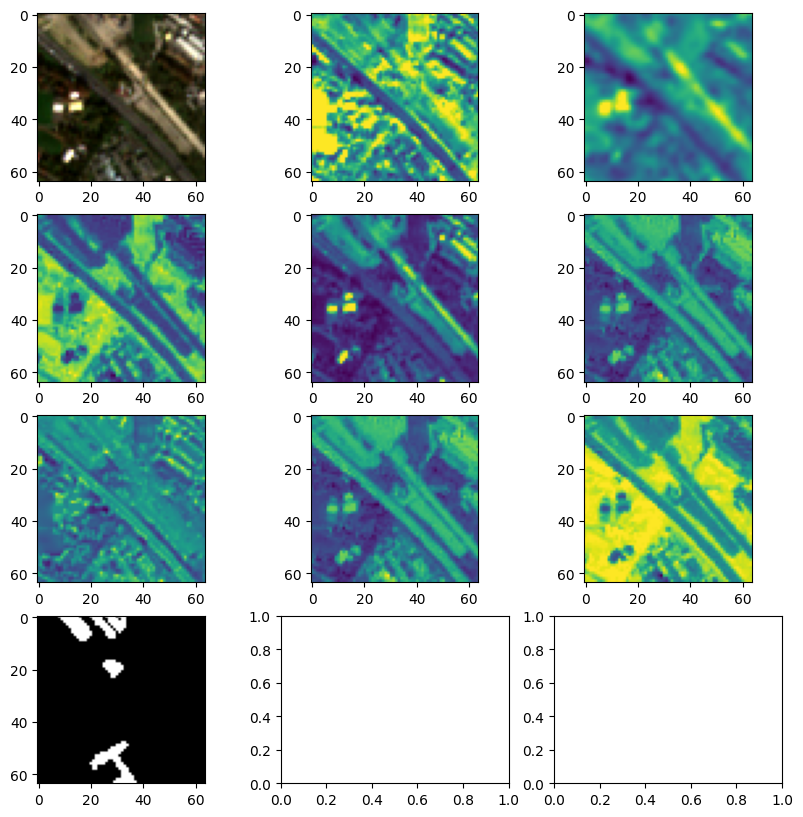

In [57]:

model.cpu()

x,y,mask = next(iter(val_loader))
x,y,mask = x.float(), y.float(), mask.float()
# x,y,mask = x[0:1,:,:,:], y[0:1,:,:,:], mask[0:1,:,:,:]
# x,y,mask = x.cpu(), y.tocpu(), mask.to(device)
x=torch.cat([x,mask],axis=1)
y_pred = model(x)
batch_img=0
fig, ax = plt.subplots(4, 3, figsize=(10,10))

ax[0, 0].imshow((x[batch_img, 0:3, :, :]).permute(1,2,0).detach().numpy())
ax[0, 1].imshow(x[batch_img, 3, :, :].detach().numpy())
ax[0, 2].imshow(x[batch_img, 4, :, :].detach().numpy())
ax[1, 0].imshow(x[batch_img, 5, :, :].detach().numpy())
ax[1, 1].imshow(x[batch_img,0,:,:].detach().numpy())
ax[1, 2].imshow(x[batch_img, 6, :, :].detach().numpy())
ax[2, 0].imshow(x[batch_img, 7, :, :].detach().numpy())
ax[2, 1].imshow(x[batch_img, 8, :, :].detach().numpy())
ax[2, 2].imshow(x[batch_img, 9, :, :].detach().numpy())
ax[3,0].imshow(mask[batch_img,0,:,:].detach().numpy(),cmap="gray")
# ax[2, 0].imshow(x[batch_img, 6, :, :].detach().numpy())
# ax[2, 1].imshow(y[batch_img, 6, :, :].detach().numpy())
# # ax[2, 2].imshow(y_pred[batch_img, 6, :, :].detach().numpy())
# ax[3, 0].imshow(x[batch_img, 7, :, :].detach().numpy())
# ax[3, 1].imshow(y[batch_img, 7, :, :].detach().numpy())
# # ax[3, 2].imshow(y_pred[batch_img, 7, :, :].detach().numpy())
# ax[4, 0].imshow(x[batch_img, 8, :, :].detach().numpy())
# ax[4, 1].imshow(y[batch_img, 8, :, :].detach().numpy())
# # ax[4, 2].imshow(y_pred[batch_img, 8, :, :].detach().numpy())
# ax[5, 0].imshow(x[batch_img, 9, :, :].detach().numpy())
# ax[5, 1].imshow(y[batch_img, 9, :, :].detach().numpy())
# # ax[5, 2].imshow(y_pred[batch_img, 9, :, :].detach().numpy())
plt.show()


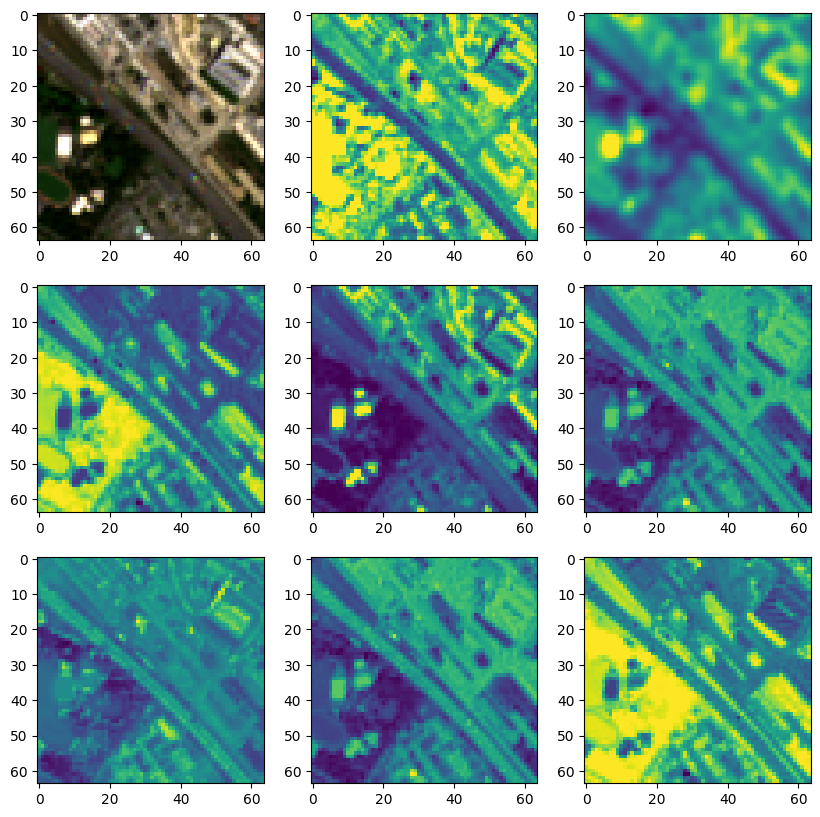

In [58]:
fig, ax = plt.subplots(3, 3, figsize=(10,10))

ax[0, 0].imshow((y[batch_img, 0:3, :, :]).permute(1,2,0).detach().numpy())
ax[0, 1].imshow(y[batch_img, 3, :, :].detach().numpy())
ax[0, 2].imshow(y[batch_img, 4, :, :].detach().numpy())
ax[1, 0].imshow(y[batch_img, 5, :, :].detach().numpy())
ax[1, 1].imshow(y[batch_img,0,:,:].detach().numpy())
ax[1, 2].imshow(y[batch_img, 6, :, :].detach().numpy())
ax[2, 0].imshow(y[batch_img, 7, :, :].detach().numpy())
ax[2, 1].imshow(y[batch_img, 8, :, :].detach().numpy())
ax[2, 2].imshow(y[batch_img, 9, :, :].detach().numpy())


plt.show()

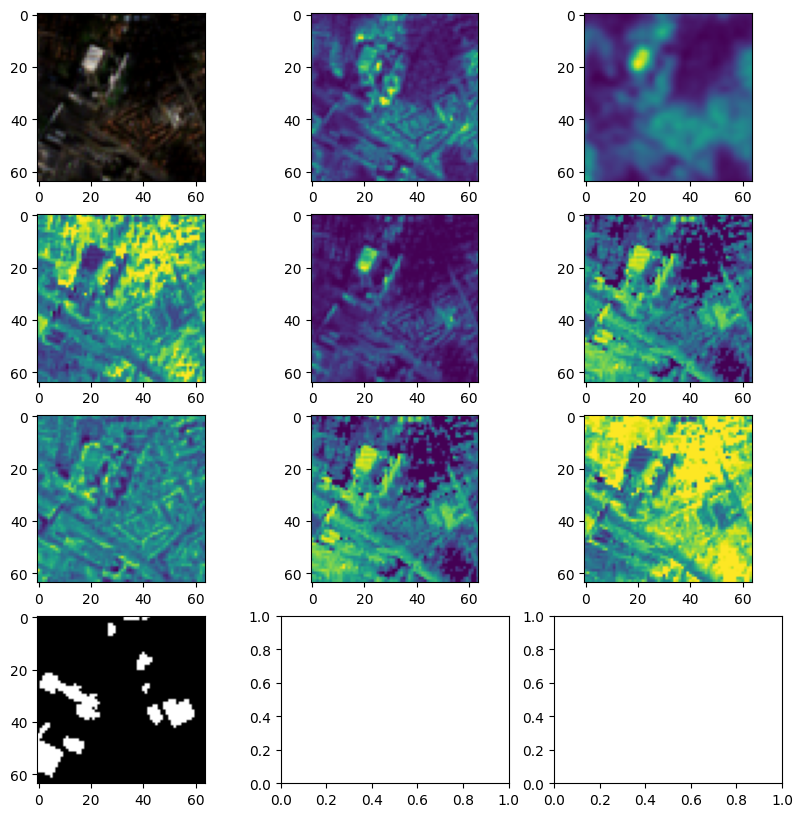

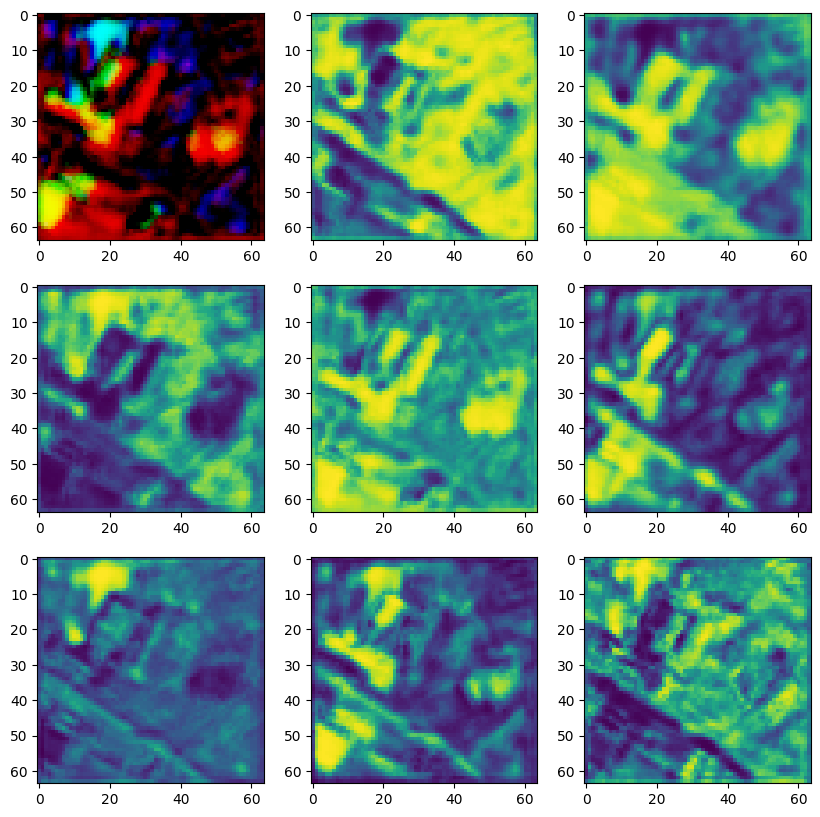

In [85]:
model.cpu()

x,y,mask = next(iter(val_loader))
x,y,mask = x.float(), y.float(), mask.float()
# x,y,mask = x[0:1,:,:,:], y[0:1,:,:,:], mask[0:1,:,:,:]
# x,y,mask = x.cpu(), y.tocpu(), mask.to(device)
x=torch.cat([x,mask],axis=1)
y_pred = model(x)
batch_img=0
fig, ax = plt.subplots(4, 3, figsize=(10,10))

ax[0, 0].imshow((y[batch_img, 0:3, :, :]).permute(1,2,0).detach().numpy())
ax[0, 1].imshow(y[batch_img, 3, :, :].detach().numpy())
ax[0, 2].imshow(y[batch_img, 4, :, :].detach().numpy())
ax[1, 0].imshow(y[batch_img, 5, :, :].detach().numpy())
ax[1, 1].imshow(y[batch_img,0,:,:].detach().numpy())
ax[1, 2].imshow(y[batch_img, 6, :, :].detach().numpy())
ax[2, 0].imshow(y[batch_img, 7, :, :].detach().numpy())
ax[2, 1].imshow(y[batch_img, 8, :, :].detach().numpy())
ax[2, 2].imshow(y[batch_img, 9, :, :].detach().numpy())
ax[3,0].imshow(mask[batch_img,0,:,:].detach().numpy(),cmap="gray")
plt.show()

fig, ax = plt.subplots(3, 3, figsize=(10,10))
ax[0, 0].imshow((y_pred[batch_img, 0:3, :, :]).permute(1,2,0).detach().numpy())
ax[0, 1].imshow(y_pred[batch_img, 3, :, :].detach().numpy())
ax[0, 2].imshow(y_pred[batch_img, 4, :, :].detach().numpy())
ax[1, 0].imshow(y_pred[batch_img, 5, :, :].detach().numpy())
ax[1, 1].imshow(y_pred[batch_img,0,:,:].detach().numpy())
ax[1, 2].imshow(y_pred[batch_img, 6, :, :].detach().numpy())
ax[2, 0].imshow(y_pred[batch_img, 7, :, :].detach().numpy())
ax[2, 1].imshow(y_pred[batch_img, 8, :, :].detach().numpy())
ax[2, 2].imshow(y_pred[batch_img, 9, :, :].detach().numpy())
plt.show()
plt.show()

In [ ]:
print(y_pred.max(1).shape())